# Implementation of REINFORCE Algorithm

## What we did in this milestone?

We implemented the Policy Gradient algorithm REINFORCE.  To test the performance and efficacy we evaluated it using simulated data. 


Just as a reminder the REIN

Next we will present the results and the challengs that we faced




## Reinforce Deep Setup

### Loss Function

$$
L=-\sum_{k,t}Q_{k,t}log(\pi(s_{k,t},a_{k,t}))
$$

where 
$$
Q_{k,t}=\sum_{i=0}\gamma^ir_i
$$

## Challenge: n-asset dimensional action space parametrization. 

Our action space is has dimension $n$ where $n$ correponds to the number of assets in our portfolio. To parametrize our policy we followed the standard solution in the univariate case; creation a Gaussian Policy

### Gaussian Policy

$$
\pi(a |s,\boldsymbol\theta):=\frac{1}{\sigma(s,\boldsymbol\theta)\sqrt{2\pi}}exp(-\frac{(a-\mu(s,\boldsymbol\theta))^2}{2\sigma(s,\boldsymbol\theta)^2})
$$

#### Linear Parametrization

$$
\theta:=[\boldsymbol{\theta_{\mu}},\boldsymbol{\theta_{\sigma}}]
$$

$$
\mu(s,\boldsymbol\theta) :=\boldsymbol{\theta_{\mu}}^T \pmb{x}(s)
$$

$$
\sigma(s,\boldsymbol\theta) :=exp(\boldsymbol{\theta_{\sigma}}^T \pmb{x}(s))
$$

#### Gradients

$$
\nabla ln\pi(a|s,\boldsymbol\theta_\mu)=\frac{1}{\sigma(s,\boldsymbol\theta)^2}(a-\mu(s,\boldsymbol\theta))\pmb{x}(s)
$$

$$
\nabla ln\pi(a|s,\boldsymbol\theta_\sigma)=\left(\frac{(a-\mu(s,\boldsymbol\theta))^2}{\sigma(s,\boldsymbol\theta)^2} -1\right)\pmb{x}(s)
$$

**The challenge with the multivariate case is that we will need to parametrize the coviariance matrix as well** While an increase of $n*n/2$ may not be that much. If we account for the interaction of asset features (specialy if we use lags) then the number of paramters grows multiplicative $n*n*features/2$

**Solution:** We decided to  use uncorrelated parametrizations i.e. we set the covariance of each individual action in the policy to 0. 

Still we calculated the mighty gradients for the multivariate case.  





##  Multivariate Case

We have a continuous multivariate case parametrized the following way:

$$
\pi(a|s,\theta)=\frac{exp\left(\frac{1}{2}(a-\mu(s,\Theta_\mu))^T\Sigma(s,\theta_\Sigma)^{-1}(a-\mu(s,\Theta_\mu))\right)}{\sqrt{(2\pi)^k|\Sigma(s,\theta_\Sigma)|}}
$$

Where

$$
\mu(s,\Theta_\mu)=\Theta f
$$

The parametrization of $\Sigma$ will be defined as

$$
\Sigma{i,j}=\sum_k^m \theta^{\sigma}_{i,j,k}f_k
$$

$f=[f_1,...,f_m]$ is the vector of $m$ features and $\Theta$ is a row matrix $\theta_i^T=[\theta_{i,1}...\theta_{i,n}]$ . Hence each of the individual means is a linear combination of the features.


Therefore to calculuate the log gradient we need to use Matrix Calculus. first, we define

$$
u=\Theta f
$$

then we can rewrite

$$
ln(\pi(a|s,\theta))=\frac{1}{2}(a-u)^T\Sigma(s,\theta_\Sigma)^{-1}(a-u) -ln(\sqrt{(2\pi)^k|\Sigma(s,\theta_\Sigma)|})
$$

By queation  [137] from http://www.math.uwaterloo.ca/~hwolkowi//matrixcookbook.pdf
$$
\nabla ln(\pi(a|s,\theta_{i,k}^\mu))=Tr[\frac{\partial g(u)}{\partial u}^T \frac{\partial u}{\partial \theta_{i,k}^\mu }]
$$

And then by equation [86] http://www.math.uwaterloo.ca/~hwolkowi//matrixcookbook.pdf
 
$$
\nabla ln(\pi(a|s,\theta_{i,k}^\mu))=Tr[(\Sigma^{-1}(a-\Theta f))^T I[i]*f_k]
$$

Where $I[i]$ is a row vector  with zeros in all rows and 1 in row $i$ This can expressed as

$$
\nabla ln(\pi(a|s,\theta_{i,k}^\mu))=\text{row}_i[\Sigma^{-1}(a-\Theta f)] * f_k
$$

For the case of  $\Sigma$ we can also follow https://stats.stackexchange.com/questions/27436/how-to-take-derivative-of-multivariate-normal-density and apply the chain rule to obtain

$$
\nabla ln(\pi(a|s,\theta_{i,j,k}^\sigma))=Tr\left[[-\frac{1}{2}(\Sigma^{-1}-\Sigma^{-1}(a-\mu(s,\Theta_\mu))(a-\mu(s,\Theta_\mu))^T \Sigma^{-1}]^T I[i=i,j=j]*f_k\right]
$$



## Evaluations

To evaluate the algorithm we  tried three different rewards functions:

* Maximum return : The Agent receives a reward on each step equals to the return of the portfolio on 1-step
* Maximum Sharpe: The Agent receives 0 as reward on each steap until the end of an episode when the agent receives the Sharpe ratio. 
* Monimum volatility : The Agent receives 0 as reward on each step until the  end of an episode when the agent receives the negative of the volatility of the portfolio. 

Important to mention that at each step the Agent observes the state that equals the previous weights in the portfolio and the last 32 log returns of each asset. 

Below we will present the case of minimum volatility as an example. The results where pretty similar for other  reward functions

In [1]:
from lib.Environment_refactored import DeepTradingEnvironment, LinearAgent
import datetime
import numpy as np
from pypfopt.efficient_frontier import EfficientFrontier
from pypfopt.plotting import plot_efficient_frontier
from pypfopt.cla import CLA

out_reward_window=datetime.timedelta(days=7)
# parameters related to the transformation of data, this parameters govern an step before the algorithm
meta_parameters = {"in_bars_count": 30,
                   "out_reward_window":out_reward_window ,
                   "state_type":"in_window_out_window"}

# parameters that are related to the objective/reward function construction
objective_parameters = {"percent_commission": .001,
                        }
print("===Meta Parameters===")
print(meta_parameters)
print("===Objective Parameters===")
print(objective_parameters)


assets_simulation_details={"asset_1":{"method":"GBM","sigma":.01,"mean":.02},
                    "asset_2":{"method":"GBM","sigma":.03,"mean":.18}}

env=DeepTradingEnvironment.build_environment_from_simulated_assets(assets_simulation_details=assets_simulation_details,
                                                                     data_hash="simulation_gbm",
                                                                     meta_parameters=meta_parameters,
                                                                     objective_parameters=objective_parameters)
cov=np.array([[assets_simulation_details["asset_1"]["sigma"]**2,0],[0,assets_simulation_details["asset_2"]["sigma"]**2]])
mus=np.array([assets_simulation_details["asset_1"]["mean"],assets_simulation_details["asset_2"]["mean"]])

ef = EfficientFrontier(mus, cov)
# weights = ef.max_sharpe(risk_free_rate=0)
weights = ef.min_volatility()
print("minum volatility weights",weights)


===Meta Parameters===
{'in_bars_count': 30, 'out_reward_window': datetime.timedelta(days=7), 'state_type': 'in_window_out_window'}
===Objective Parameters===
{'percent_commission': 0.001}
minum volatility weights OrderedDict([(0, 0.8999999999996016), (1, 0.1000000000003984)])


In [2]:

x=np.array(list(weights.values())).reshape(-1,1)
p_vol=np.sqrt(np.matmul(np.matmul(x.T,cov),x))
p_sharpe=np.matmul(x.T,mus)/p_vol
linear_agent=LinearAgent(environment=env,out_reward_window_td=out_reward_window,
                         reward_function="cum_return",sample_observations=32)
linear_agent.set_plot_weights(weights=np.array(list(weights.values())),
                              benchmark_G=-p_vol.ravel()[0])

pre-sampling indices: 100%|██████████| 1373/1373 [00:16<00:00, 84.11it/s]


  2%|▏         | 200/10000 [00:17<14:04, 11.61it/s]

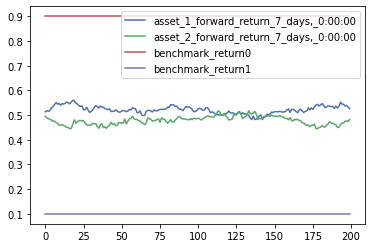

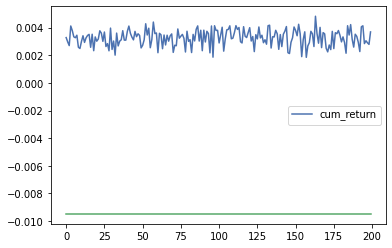

  4%|▍         | 400/10000 [00:34<13:56, 11.48it/s]

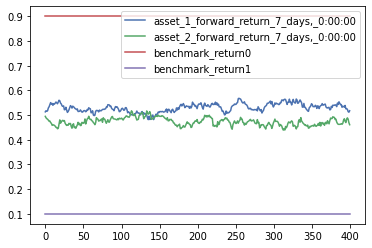

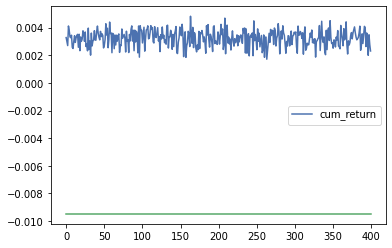

  6%|▌         | 600/10000 [00:51<13:48, 11.35it/s]

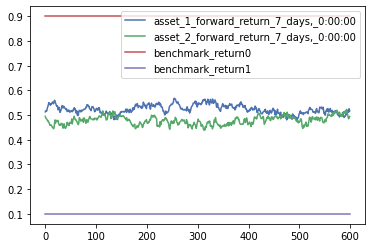

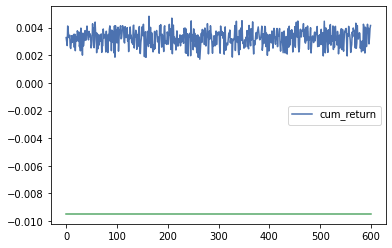

  8%|▊         | 800/10000 [01:08<12:56, 11.85it/s]

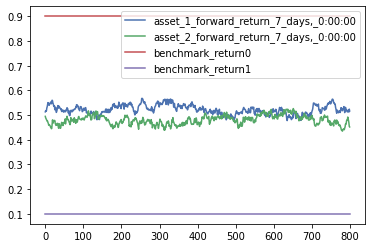

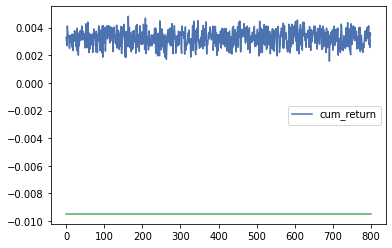

 10%|█         | 1000/10000 [01:26<12:48, 11.71it/s]

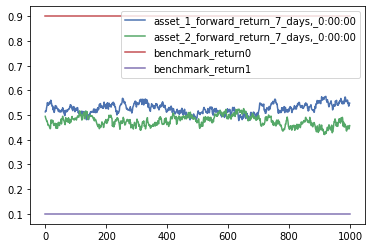

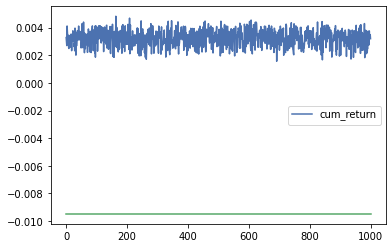

 12%|█▏        | 1199/10000 [01:43<12:35, 11.65it/s]

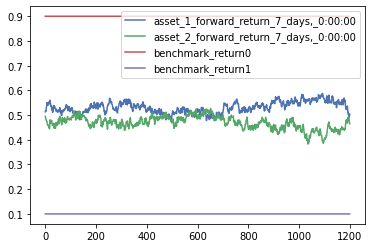

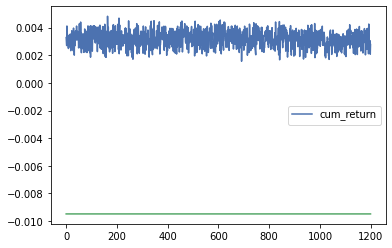

 14%|█▍        | 1399/10000 [02:01<12:16, 11.67it/s]

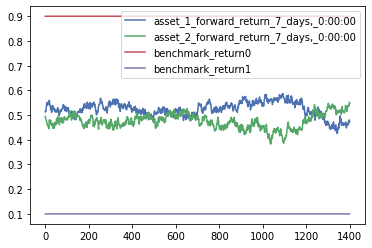

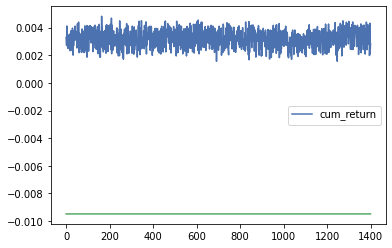

 16%|█▌        | 1599/10000 [02:18<11:55, 11.74it/s]

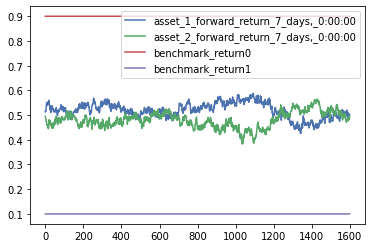

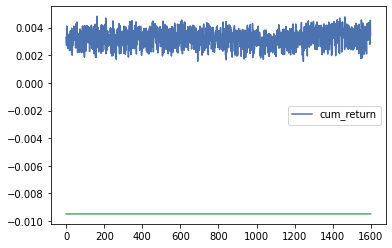

 18%|█▊        | 1799/10000 [02:36<11:36, 11.78it/s]

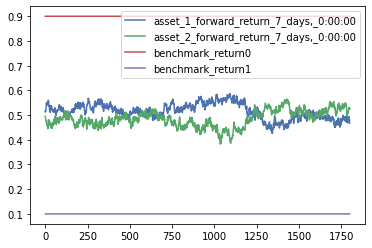

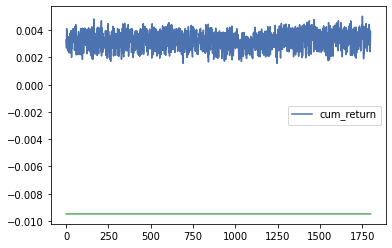

 20%|█▉        | 1999/10000 [02:53<11:42, 11.39it/s]

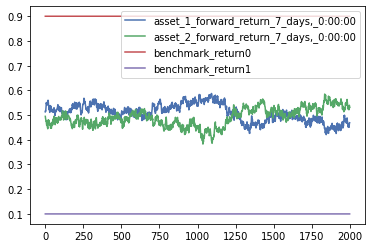

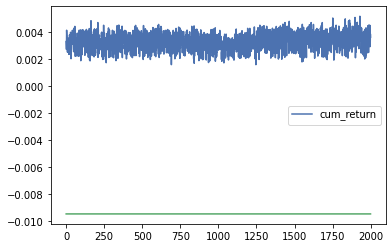

 22%|██▏       | 2199/10000 [03:11<11:24, 11.40it/s]

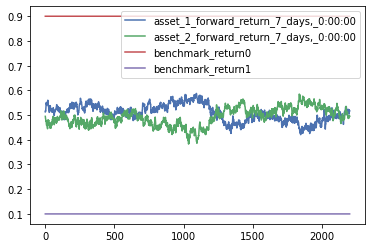

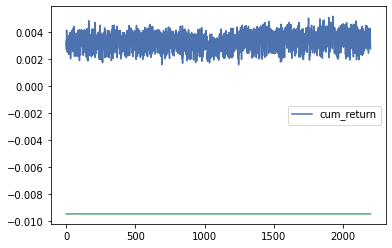

 24%|██▍       | 2399/10000 [03:28<10:47, 11.73it/s]

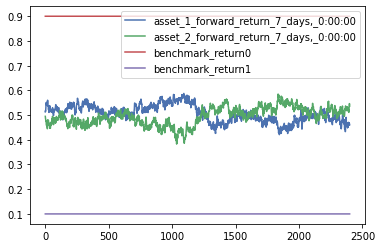

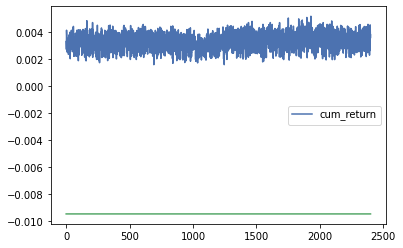

 26%|██▌       | 2599/10000 [03:46<10:29, 11.76it/s]

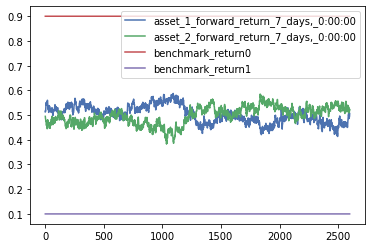

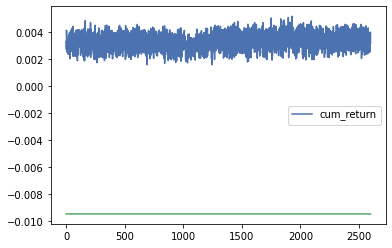

 28%|██▊       | 2799/10000 [04:04<10:09, 11.82it/s]

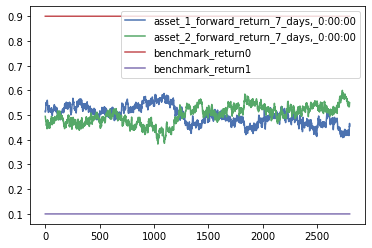

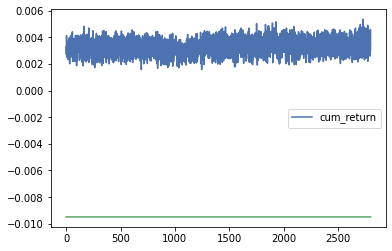

 30%|███       | 3000/10000 [04:21<09:49, 11.87it/s]

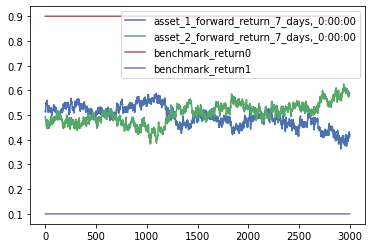

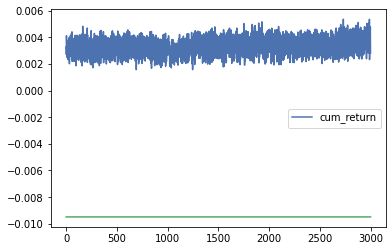

 32%|███▏      | 3200/10000 [04:38<09:51, 11.49it/s]

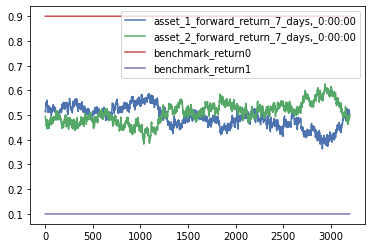

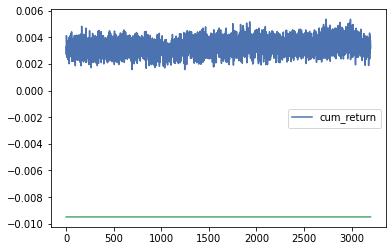

 34%|███▍      | 3400/10000 [04:56<09:31, 11.55it/s]

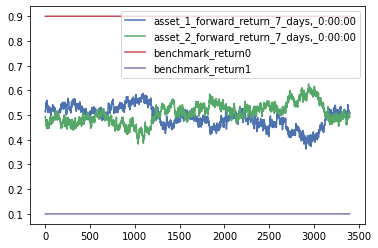

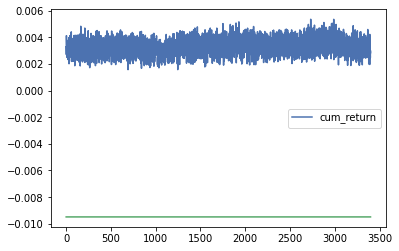

 36%|███▌      | 3600/10000 [05:13<09:34, 11.13it/s]

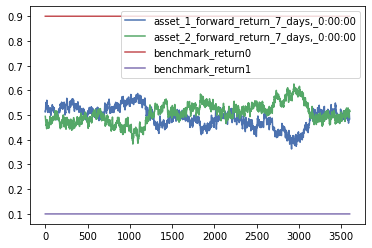

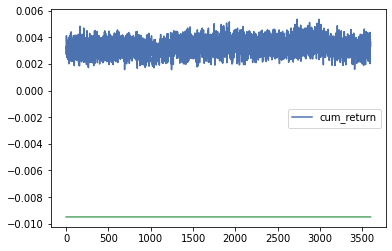

 38%|███▊      | 3799/10000 [05:31<08:56, 11.56it/s]

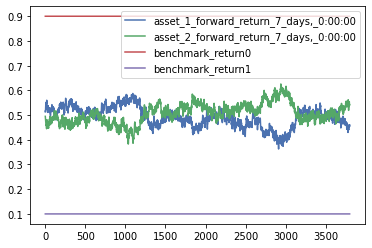

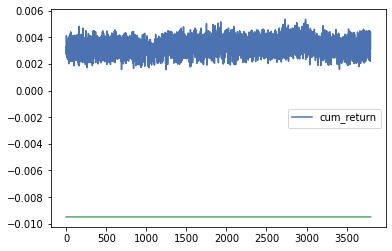

 40%|████      | 4000/10000 [05:48<08:30, 11.76it/s]

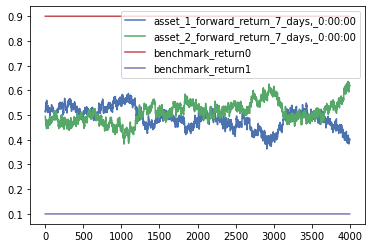

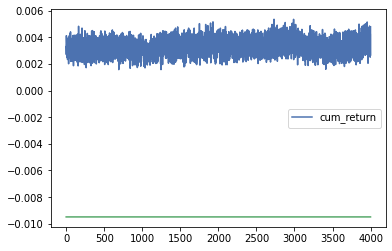

 42%|████▏     | 4200/10000 [06:06<08:10, 11.83it/s]

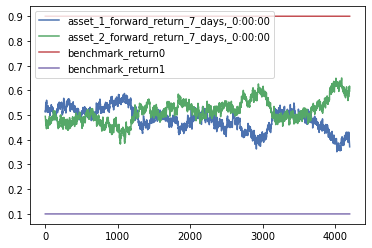

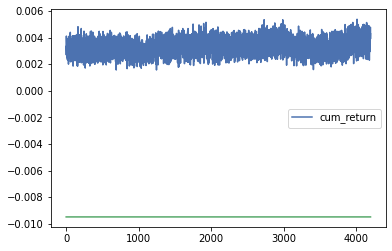

 44%|████▍     | 4400/10000 [06:23<07:49, 11.94it/s]

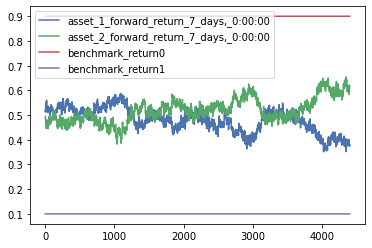

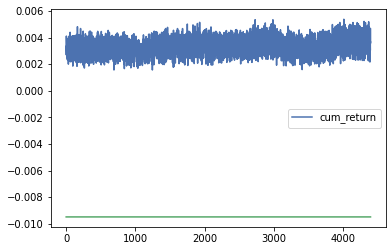

 46%|████▌     | 4600/10000 [06:41<07:42, 11.68it/s]

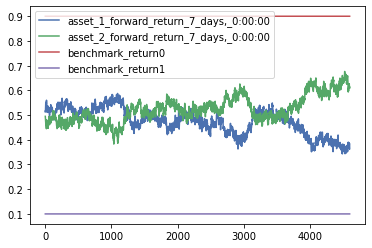

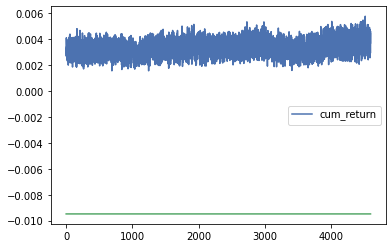

 48%|████▊     | 4800/10000 [06:58<07:27, 11.61it/s]

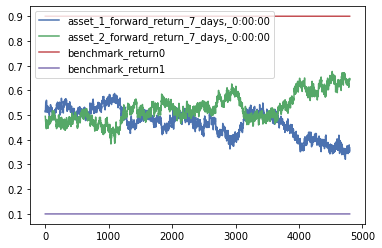

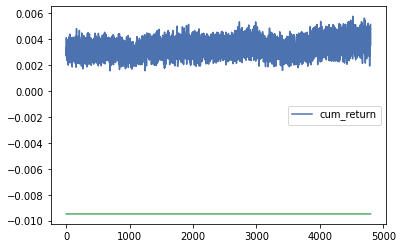

 50%|█████     | 5000/10000 [07:16<07:14, 11.52it/s]

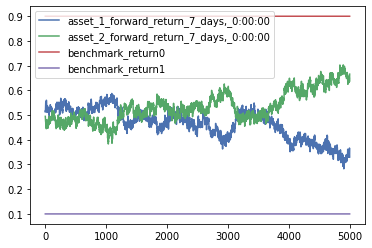

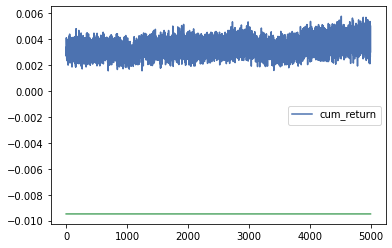

 52%|█████▏    | 5200/10000 [07:34<06:49, 11.72it/s]

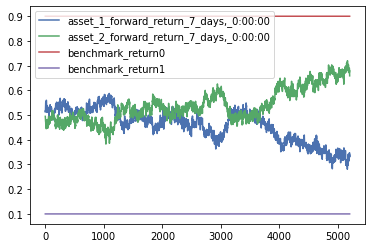

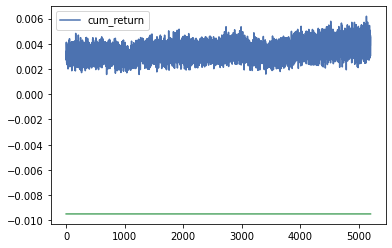

 54%|█████▍    | 5400/10000 [07:51<06:26, 11.89it/s]

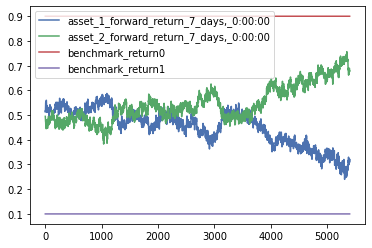

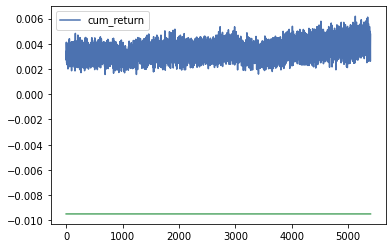

 56%|█████▌    | 5600/10000 [08:09<06:10, 11.88it/s]

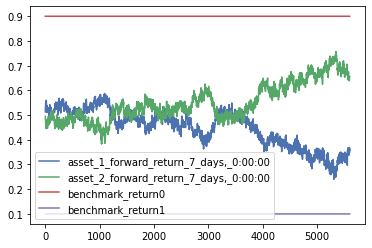

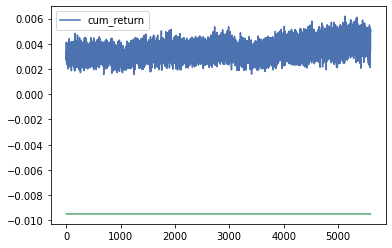

 58%|█████▊    | 5800/10000 [08:26<05:58, 11.71it/s]

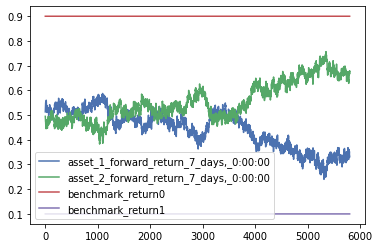

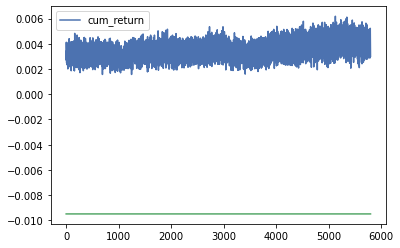

 60%|██████    | 6000/10000 [08:44<05:50, 11.42it/s]

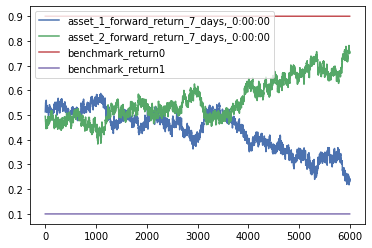

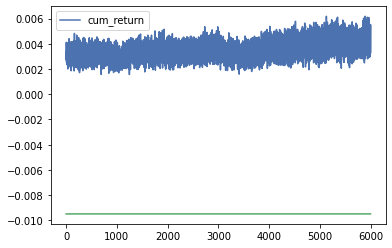

 62%|██████▏   | 6200/10000 [09:01<05:19, 11.89it/s]

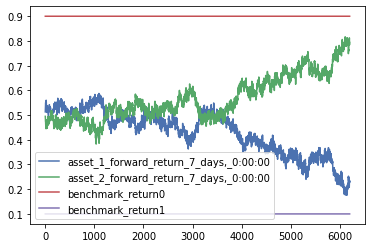

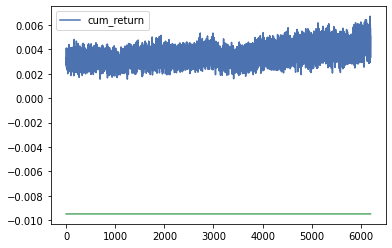

 64%|██████▍   | 6400/10000 [09:19<05:02, 11.89it/s]

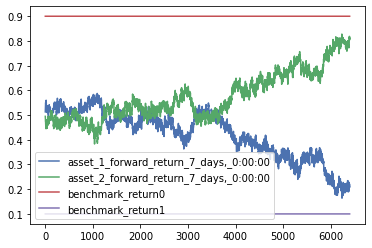

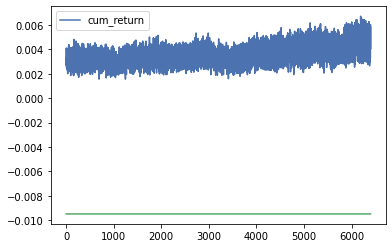

 66%|██████▌   | 6600/10000 [09:37<04:49, 11.74it/s]

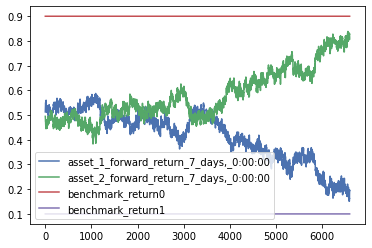

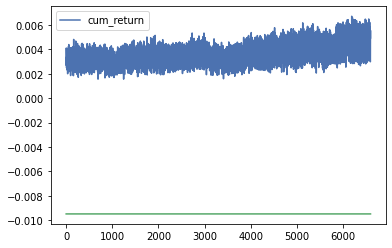

 68%|██████▊   | 6800/10000 [09:54<04:34, 11.64it/s]

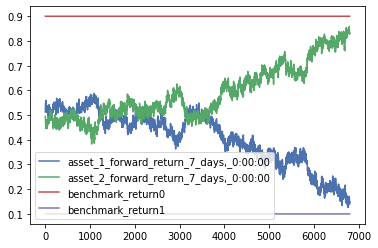

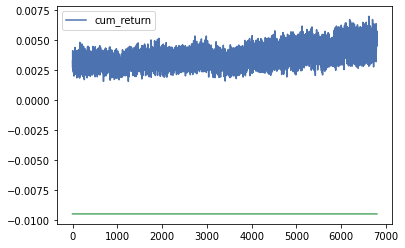

 70%|███████   | 7000/10000 [10:12<04:15, 11.72it/s]

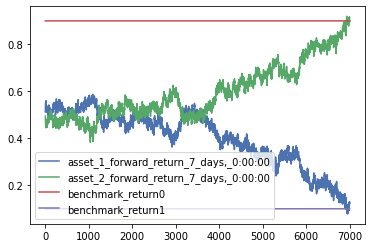

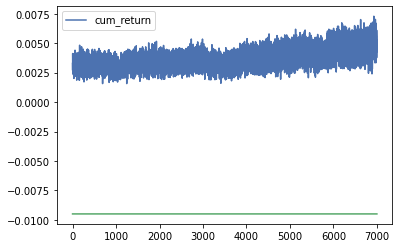

 72%|███████▏  | 7199/10000 [10:30<03:57, 11.79it/s]

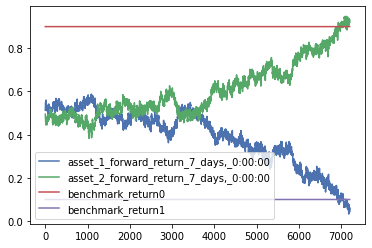

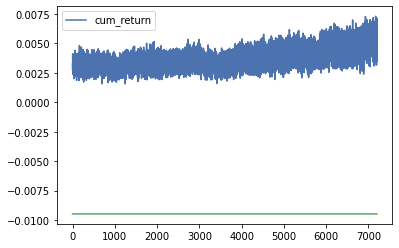

 74%|███████▍  | 7399/10000 [10:47<03:45, 11.54it/s]

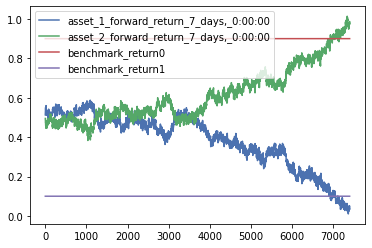

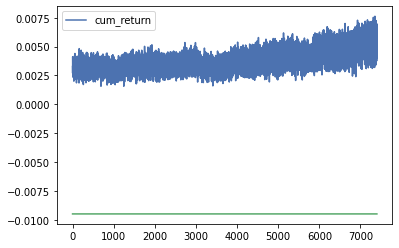

 76%|███████▌  | 7599/10000 [11:05<03:24, 11.74it/s]

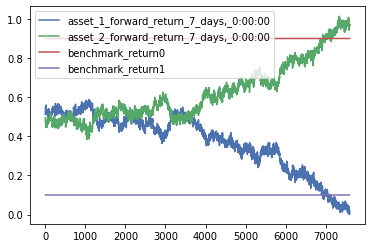

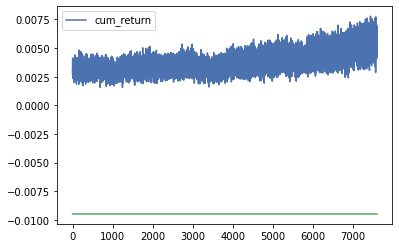

 78%|███████▊  | 7799/10000 [11:22<03:07, 11.72it/s]

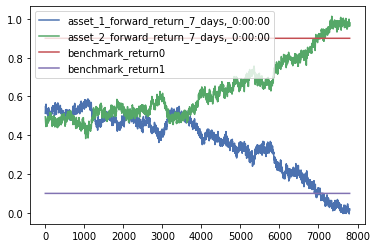

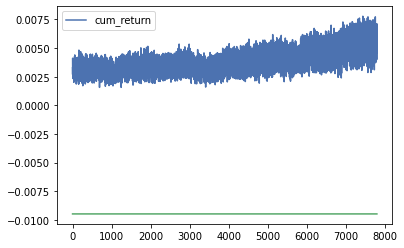

 80%|███████▉  | 7999/10000 [11:40<02:50, 11.74it/s]

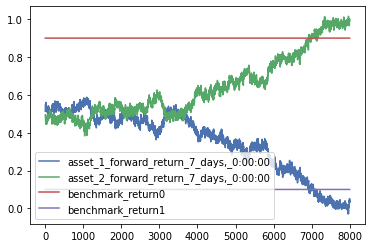

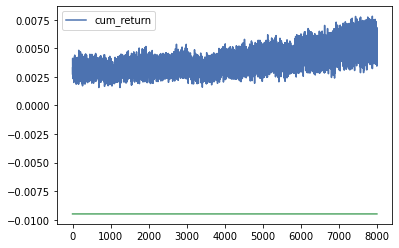

 82%|████████▏ | 8199/10000 [11:57<02:35, 11.56it/s]

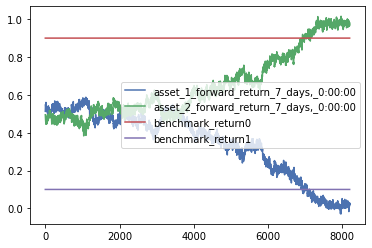

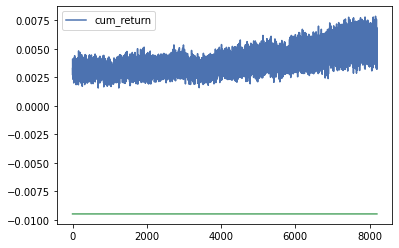

 84%|████████▍ | 8399/10000 [12:15<02:16, 11.73it/s]

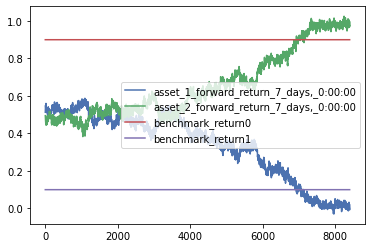

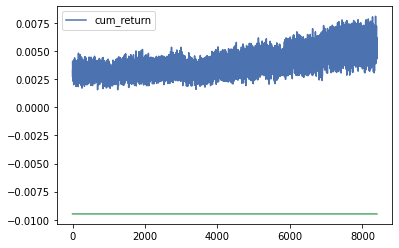

 86%|████████▌ | 8599/10000 [12:33<02:07, 10.99it/s]

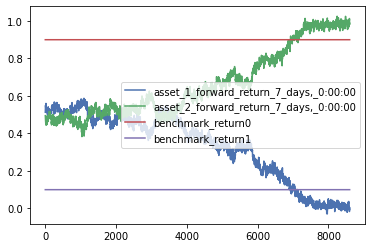

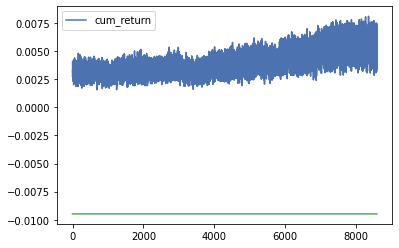

 88%|████████▊ | 8799/10000 [12:50<01:42, 11.71it/s]

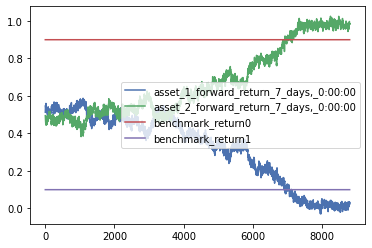

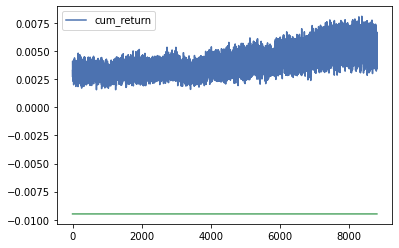

 90%|█████████ | 9000/10000 [13:08<01:24, 11.78it/s]

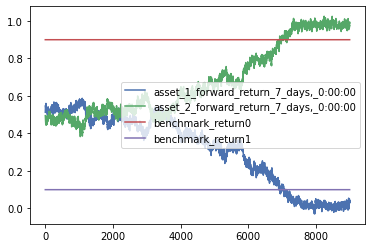

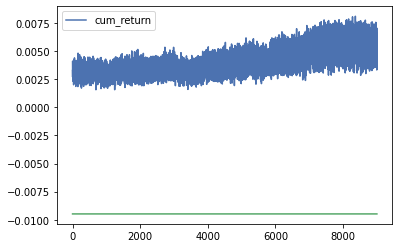

 92%|█████████▏| 9200/10000 [13:26<01:07, 11.86it/s]

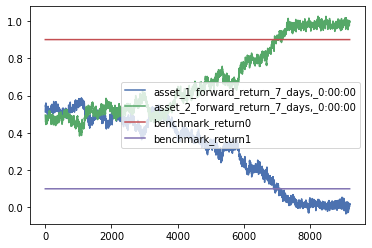

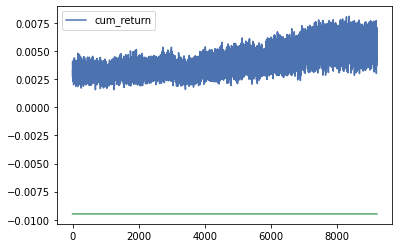

 94%|█████████▍| 9399/10000 [13:43<00:51, 11.66it/s]

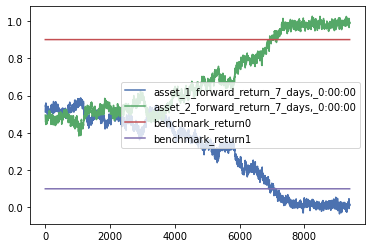

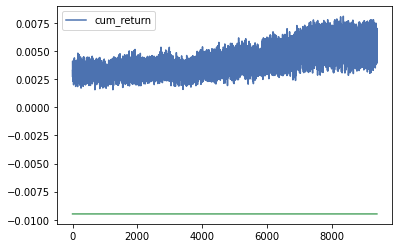

 96%|█████████▌| 9599/10000 [14:01<00:34, 11.77it/s]

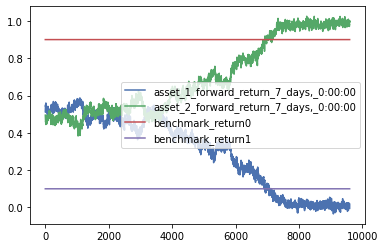

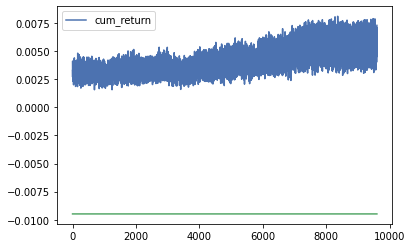

 98%|█████████▊| 9799/10000 [14:18<00:17, 11.77it/s]

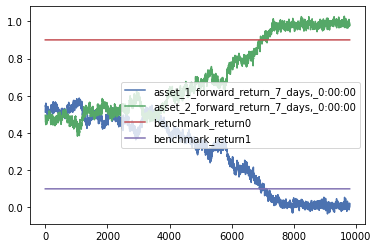

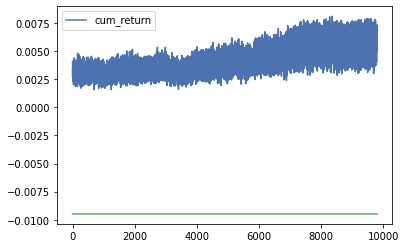

100%|█████████▉| 9999/10000 [14:36<00:00, 11.76it/s]

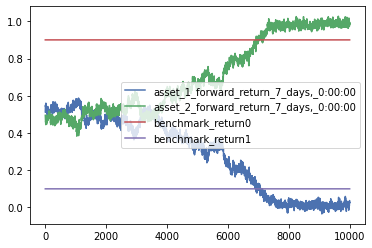

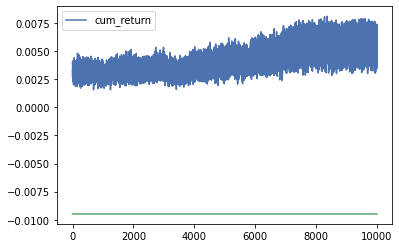

[asset_1_forward_return_7_days,_0:00:00    0.513042
 asset_2_forward_return_7_days,_0:00:00    0.494864
 dtype: float64,
 asset_1_forward_return_7_days,_0:00:00    0.517657
 asset_2_forward_return_7_days,_0:00:00    0.488793
 dtype: float64,
 asset_1_forward_return_7_days,_0:00:00    0.515162
 asset_2_forward_return_7_days,_0:00:00    0.485435
 dtype: float64,
 asset_1_forward_return_7_days,_0:00:00    0.517700
 asset_2_forward_return_7_days,_0:00:00    0.483025
 dtype: float64,
 asset_1_forward_return_7_days,_0:00:00    0.528711
 asset_2_forward_return_7_days,_0:00:00    0.479656
 dtype: float64,
 asset_1_forward_return_7_days,_0:00:00    0.533708
 asset_2_forward_return_7_days,_0:00:00    0.475097
 dtype: float64,
 asset_1_forward_return_7_days,_0:00:00    0.542142
 asset_2_forward_return_7_days,_0:00:00    0.475676
 dtype: float64,
 asset_1_forward_return_7_days,_0:00:00    0.550489
 asset_2_forward_return_7_days,_0:00:00    0.469514
 dtype: float64,
 asset_1_forward_return_7_days,_

In [3]:
# linear_agent.REINFORCE_fit()
linear_agent.REINFORCE_fit(add_baseline=False)

## Results

### The Good

* REINFORCE Converges to the expected portfolio using different reward functions.
* REINFORCE Convergence is agnostic of estimation of a covariance matrix. 
* REINFORCE Can allow us easily to add extra features to the parametrization of our function ( technical indicators, sentiment indices , etc)
* REINFORCE finds the optimal policy even when the rewards its stochastic. 

### The Bad

* The speed of convergence is pretty slow. it took around 10+ minutes for convergence. This was expected as REINFORCE algorithm is known for having a high variance. 
* The convergence was achieved by comparing the results with the expected answer. However the L2 Norm of the parametrization vectors continues to bounce even after convergence. model overfit?. 
* The convergence seem to requiry a dynamic $\alpha$ to avoid bouncing out of an optimal result.
* Naive implementation of SGD cant be paralelized. 

### The Ugly

* REINFORCE is an on-policy method.  This means that is sample-ineficient as we cant use episodes generated by old policies. How can we proove that if the market is action independent then we can reuse episodes?




## Next Steps

* Explore REINFORCE with baseline and A2C method. 
* Implement parametrization in TensorFlow to be able to use non linear and stronger optimizaers and paralelization. 
